In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np

WARNING (theano.configdefaults): Only clang++ is supported. With g++, we end up with strange g++/OSX bugs.


Model
-----
Consider the following true generative model:
    
$$ x_{true} \sim \textrm{Normal}(2,1) $$
$$ y_{true} \sim \textrm{Normal}(\textrm{exp}(x_{true}),1)$$
$$ z_{data} \sim \textrm{Normal}(x_{true} + y_{true},0.75)$$

Where $x_{true}$ is a scalar, $y_{true}$ is a vector of length 2, and $z_{data}$ is a $2\times 20$ matrix.

We can simulate this using Numpy:

In [2]:
ndims = 2
nobs = 20

xtrue = np.random.normal(scale=2., size=1)
ytrue = np.random.normal(loc=np.exp(xtrue), scale=1, size=(ndims, 1))
zdata = np.random.normal(loc=xtrue + ytrue, scale=.75, size=(ndims, nobs))

`zdata` is observed but `xtrue` and `ytrue` are not. Thus x and y are unknown, and we want to come up with posterior distributions for them. 

Build Model
-----------

Now we want to do inference assuming the following model:

$$ x \sim \textrm{Normal}(0,1) $$
$$ y \sim \textrm{Normal}(\textrm{exp}(x),2)$$
$$ z \sim \textrm{Normal}(x + y,0.75)$$

The aim here is to get posteriors over $x$ and $y$ given the data we have about $z$ (`zdata`).

We create a new `Model` objects, and do operations within its context. The `with` lets PyMC know this model is the current model of interest. 

We construct new random variables with the constructor for its prior distribution such as `Normal` while within a model context (inside the `with`). When you make a random variable it is automatically added to the model. The constructor returns a Theano variable.

Using the constructor may specify the name of the random variable, the parameters of a random variable's prior distribution, as well as the shape of the random variable. We can specify that a random variable is observed by specifying the data that was observed.

In [3]:
with pm.Model() as model:
    x = pm.Normal('x', mu=0., sd=1)
    y = pm.Normal('y', mu=np.exp(x), sd=2., shape=(ndims, 1)) # here, shape is telling us it's a vector rather than a scalar.
    z = pm.Normal('z', mu=x + y, sd=.75, observed=zdata) # shape is inferred from zdata

A parenthetical note on the parameters for the normal. Variance is encoded as `tau`, indicating precision, which is simply inverse variance (so $\tau=\sigma^{-2}$ ). This is used because the gamma function is the conjugate prior for precision, and must be inverted to get variance. Encoding in terms of precision saves the inversion step in cases where variance is actually modeled using gamma as a prior.

Fit Model
---------
We need a starting point for our sampling. The `find_MAP` function finds the maximum a posteriori point (MAP), which is often a good choice for starting point. `find_MAP` uses an optimization algorithm (`scipy.optimize.fmin_l_bfgs_b`, or [BFGS](http://en.wikipedia.org/wiki/BFGS_method), by default) to find the local maximum of the log posterior.

Note that this `with` construction is used again. Functions like `find_MAP` and `HamiltonianMC` need to have a model in their context. `with` activates the context of a particular model within its block.

In [4]:
with model:
    start = pm.find_MAP()

Points in parameter space are represented by dictionaries with parameter names as they keys and the value of the parameters as the values.

In [5]:
print("MAP found:")
print("x:", start['x'])
print("y:", start['y'])

print("Compare with true values:")
print("ytrue", ytrue)
print("xtrue", xtrue)

MAP found:
x: 1.0679746963606171
y: [[ 3.33702529]
 [ 3.57463881]]
Compare with true values:
ytrue [[ 3.09049121]
 [ 3.4475357 ]]
xtrue [ 1.17545009]


We will use NUTS to sample from the posterior as implemented by the `NUTS` step method class.

In [6]:
with model:
    step = pm.NUTS()

The `sample` function takes a number of steps to sample, a step method, a starting point. It returns a trace object which contains our samples.

In [7]:
with model: 
    trace = pm.sample(3000, step, start)

100%|██████████| 3000/3000 [00:01<00:00, 1991.89it/s]


To use more than one sampler, pass a list of step methods to `sample`. 

The trace object can be indexed by the variables in the model, returning an array with the first index being the sample index
and the other indexes the shape of the parameter. Thus for this example:

In [8]:
trace[y].shape

(3000, 2, 1)

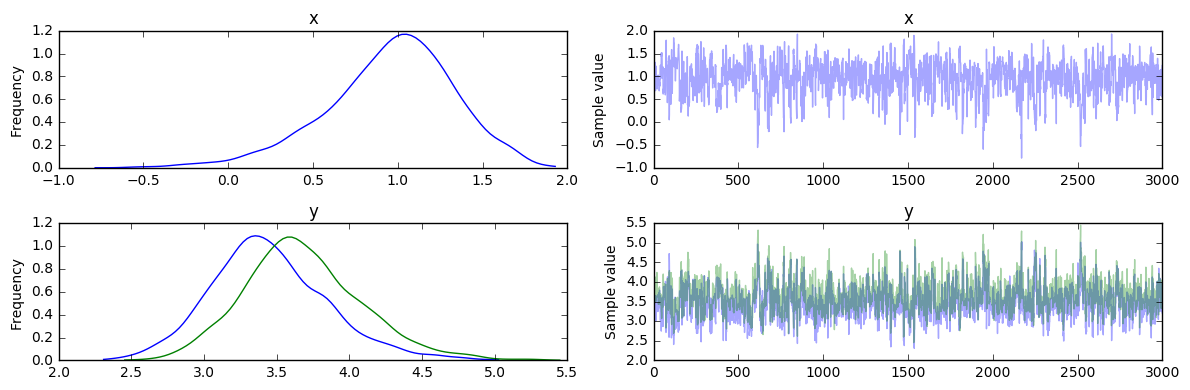

In [9]:
pm.traceplot(trace);

## PyMC Internals

### Model 

The `Model` class has very simple internals: just a list of unobserved variables (`Model.vars`) and a list of factors which go into computing the posterior density (`Model.factors`) (see model.py for more).

A Python "`with model:`" block has `model` as the current model. Many functions, like `find_MAP` and `sample`, must be in such a block to work correctly by default. They look in the current context for a model to use. You may also explicitly specify the model for them to use. This allows us to treat the current model as an implicit parameter to these functions. 

### Distribution Classes

`Normal` and other distributions are actually `Distribution` subclasses. The constructors have different behavior depending on whether they are called with a name argument or not (string argument in 1st slot). This allows PyMC to have intuitive model specification syntax and still distinguish between random variables and distributions.

When a `Distribution` constructor is called:

* Without a name argument, it simply constructs a distribution object and returns it. It won't construct a random variable. This object has properties like `logp` (density function) and `expectation`.
* With a name argument, it constructs a random variable using the distrubtion object as the prior distribution and inserts this random variable into the current model. Then the constructor returns the random variable. 
